# Importing Dependencies 

In [70]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.layers import Input, Conv2D,Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, Add, Concatenate
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.layers import MultiHeadAttention,LayerNormalization,TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model

# Loading Data + Augmentation Pipeline Generation

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
# Kaggle train data 
import pandas as pd
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train_x = train.drop('label',axis='columns')
train_x = np.array(train_x)
train_x = train_x/255
train_x = train_x.reshape((42000,28,28))
train_y = train.label

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(train_x,train_y,test_size=0.2,random_state=10)

In [8]:
X_train = np.expand_dims(X_train,-1)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
train_data = train_datagen.flow(X_train,y_train,batch_size=50)

In [10]:
valid_data = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
    
valid_data = (valid_data
              .batch(32)
              .prefetch(buffer_size=tf.data.AUTOTUNE))

In [11]:
# Kaggle Test data
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test = np.array(test).reshape((28000,28,28))
test = test/255

# MODELS

<h2 style="color:blue;"> ResNet

In [12]:
def skipping_block(inp,filters):
    x = Conv2D(filters,(3,3),padding='same',activation='relu')(inp)
    x = Conv2D(filters,3,padding='same',activation='relu')(x)
    x = BatchNormalization(-1)(x)
    x = Add()([x,inp])
    return x
    
inp = Input(shape=(28,28,1))
x = Conv2D(64,(3,3),padding='same',activation='relu')(inp)
x = Dropout(0.4)(x)
x = BatchNormalization(axis=-1)(x)
x = skipping_block(x,64)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
out = Dense(10,activation='softmax')(x)

resnet_model = Model(inp,out)
resnet_model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=3)
resnet_model.fit(train_datagen.flow(X_train,y_train,batch_size=50),validation_data=valid_data,epochs=20,callbacks=[lr_callback]) #90 epochs

Epoch 1/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9886 - loss: 0.0357 - val_accuracy: 0.9901 - val_loss: 0.0396 - learning_rate: 1.9531e-06
Epoch 2/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9903 - loss: 0.0336 - val_accuracy: 0.9901 - val_loss: 0.0399 - learning_rate: 1.9531e-06
Epoch 3/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9879 - loss: 0.0374 - val_accuracy: 0.9903 - val_loss: 0.0400 - learning_rate: 1.9531e-06
Epoch 4/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9881 - loss: 0.0367 - val_accuracy: 0.9903 - val_loss: 0.0396 - learning_rate: 1.9531e-06
Epoch 5/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9880 - loss: 0.0368 - val_accuracy: 0.9901 - val_loss: 0.0397 - learning_rate: 1.9531e-06
Epoch 6/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9898 - loss: 0.0344 - val_accuracy: 0.9901 - val_loss: 0.0401 - learning_rate: 9.7656e-07
Epoch 7/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/ste

In [18]:
resnet_model.evaluate(valid_data) 

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0345


[0.03982921317219734, 0.9900952577590942]

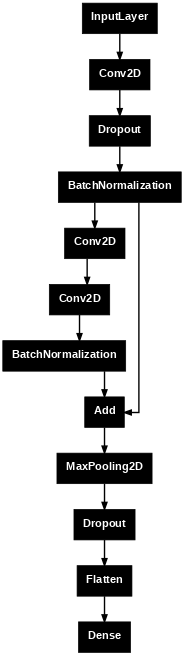

In [54]:
plot_model(resnet_model,dpi=50,to_file="renset_struct.png")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

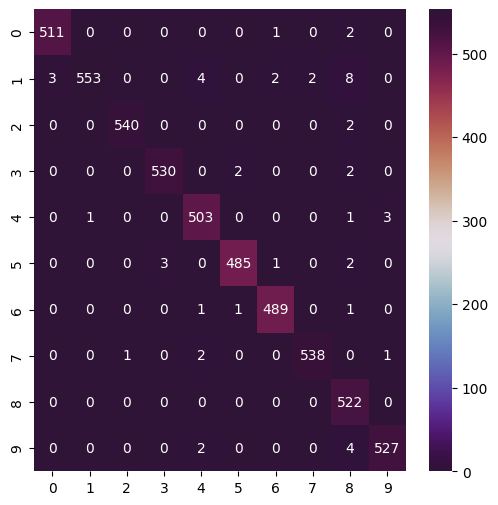

In [74]:
plt.figure(figsize=(6,6))
preds = np.argmax(resnet_model.predict(X_valid),1)
sns.heatmap(confusion_matrix(y_valid,preds),annot=True,fmt='g',cmap="twilight_shifted")

In [75]:
print(classification_report(preds,y_valid))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       514
           1       0.97      1.00      0.98       554
           2       1.00      1.00      1.00       541
           3       0.99      0.99      0.99       533
           4       0.99      0.98      0.99       512
           5       0.99      0.99      0.99       488
           6       0.99      0.99      0.99       493
           7       0.99      1.00      0.99       540
           8       1.00      0.96      0.98       544
           9       0.99      0.99      0.99       531

    accuracy                           0.99      5250
   macro avg       0.99      0.99      0.99      5250
weighted avg       0.99      0.99      0.99      5250



In [17]:
resnet_model.save("ResNet4Digits.keras")

In [57]:
result = resnet_model.predict(test)
res = np.argmax(result,axis=1)
pd.DataFrame({'ImageId':range(1,28001),'Label':res}).to_csv('resnet_result2.csv',index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<h2 style="color:blue"> DenseNet

In [19]:
def dense_block(inp,num_layers,growth_rate):
    x = inp
    for _ in range(num_layers):
        w = Conv2D(growth_rate,3,padding='same',activation='relu')(x)
        w = BatchNormalization()(w)
        x = Concatenate(axis=-1)([x,w]) # concatenated on channels 
    return x
inp = Input(shape=(28,28,1))
x = Conv2D(64,3,padding='same',activation='relu')(inp)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)
x = dense_block(x,num_layers=4,growth_rate=64)
x = MaxPooling2D()(x)
x = Conv2D(64,1,padding='same',activation='relu')(x)  #1*1 to reduce the channels
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
out = Dense(10,activation='softmax')(x)

densenet_model = Model(inp,out)
densenet_model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=3)
densenet_model.fit(train_datagen.flow(X_train,y_train,batch_size=50),validation_data=valid_data,epochs=50,callbacks=[lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


735/735 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7769 - loss: 0.7265 - val_accuracy: 0.9699 - val_loss: 0.0954 - learning_rate: 0.0010
Epoch 2/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9542 - loss: 0.1561 - val_accuracy: 0.9832 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 3/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9654 - loss: 0.1133 - val_accuracy: 0.9768 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 4/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9725 - loss: 0.0939 - val_accuracy: 0.9815 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 5/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9739 - loss: 0.0916 - val_accuracy: 0.9886 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 6/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9767 - loss: 0.0749 - val_accuracy: 0.9878 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 7/50
735/735 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9789 - loss: 0.0694

In [80]:
densenet_model.evaluate(valid_data)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0223


[0.015484107658267021, 0.9956190586090088]

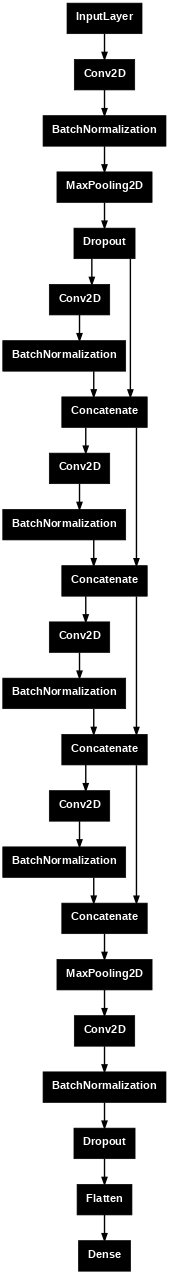

In [24]:
plot_model(densenet_model,to_file="densenet_struct.png",dpi=50)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

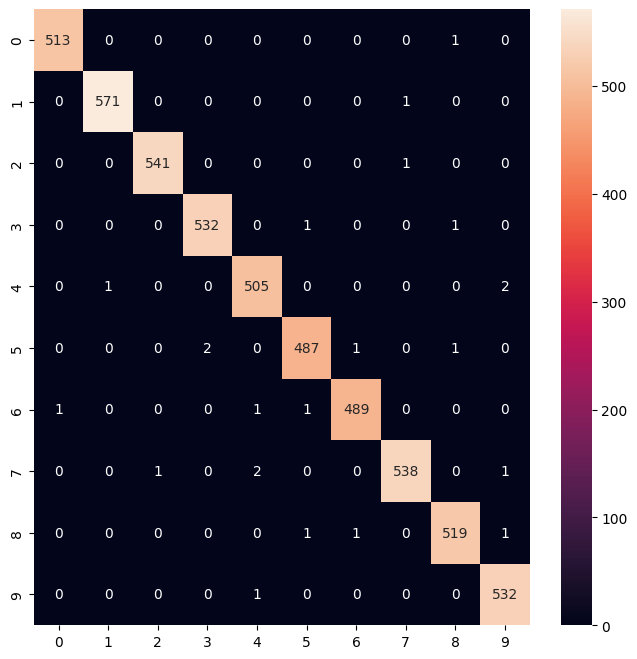

In [78]:
plt.figure(figsize=(8,8))
preds = np.argmax(densenet_model.predict(X_valid),1)
sns.heatmap(confusion_matrix(y_valid,preds),annot=True,fmt='g')

In [79]:
print(classification_report(preds,y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00       542
           3       1.00      1.00      1.00       534
           4       0.99      0.99      0.99       509
           5       0.99      0.99      0.99       490
           6       0.99      1.00      0.99       491
           7       0.99      1.00      0.99       540
           8       0.99      0.99      0.99       522
           9       1.00      0.99      1.00       536

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [26]:
densenet_model.save("DenseNet4Digits.keras")

In [194]:
densenet_model = tf.keras.models.load_model("/kaggle/working/DenseNet4Digits.keras")

In [ ]:
densenet_res = densenet_model.predict(test)
densenet_res = np.argmax(densenet_res,axis=1)

pd.DataFrame({'ImageId':range(1,28001),'Label':densenet_res}).to_csv('densenet_result5.csv',index=False)

<h2 style='color:blue'> ViT

In [33]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, inputs):
        patches = tf.image.extract_patches(
            images=inputs,sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],rates=[1, 1, 1, 1],padding='VALID')
        patch_dims = patches.shape[-1]
        print("Patch_dimentions:",patch_dims)
        patches = tf.reshape(patches, [-1, 16, 49])
        return patches
        
class Embeddings (tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim) :
        super().__init__()
        self.num_patches = num_patches
        self.embed = tf.keras.layers.Dense(units=projection_dim)

        
    def call(self, patch):
        patch_embed = self.embed(patch)
        print(patch_embed.shape)
        return patch_embed

inp = Input((28,28,1))
patches = Patches(7)(inp)
patch_embeds = Embeddings(16,64)(patches) 
pos_embed = tf.Variable(tf.random.normal((1,16,1)),trainable=True)

x = patch_embeds
for _ in range(3):
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    dense = Dense(64)(attention)
    x = Add()([x, dense])  # Residual connection
    dense = Dense(64)(x)
    dropout = Dropout(0.4)(dense)
    x = Add()([x,dense])  # Residual connection

x = LayerNormalization()(x)
x = Flatten()(x)
output = Dense(10, activation='softmax')(x)

vit_model = Model(inp, output)
vit_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Patch_dimentions: 49
(None, 16, 64)
(None, 16, 64)


In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=3)
vit_model.fit(train_datagen.flow(x=X_train,y=y_train),validation_data=valid_data,epochs=100,callbacks=[lr_scheduler]) #100 epochs

Epoch 1/100
Patch_dimentions: 49
(None, 16, 64)
Patch_dimentions: 49
(None, 16, 64)
1142/1149 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6272 - loss: 1.1473Patch_dimentions: 49
(None, 16, 64)
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6279 - loss: 1.1451 - val_accuracy: 0.8909 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 2/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8444 - loss: 0.4965 - val_accuracy: 0.9091 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 3/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8724 - loss: 0.4051 - val_accuracy: 0.9166 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 4/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8849 - loss: 0.3694 - val_accuracy: 0.9267 - val_loss: 0.2330 - learning_rate: 0.0010
Epoch 5/100
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8956 - loss: 0.3367 - val_accuracy: 0.9430 - val_loss: 0.1852 - learning_rate: 0.0010
Epoch 6/100
1149/1149 ━━━━━━━━

In [37]:
vit_model.evaluate(valid_data)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9705 - loss: 0.0972


[0.10012834519147873, 0.9685714244842529]

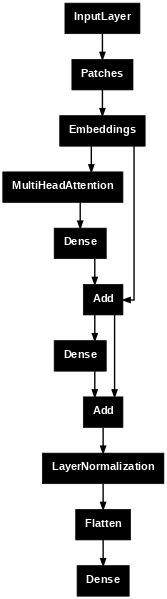

In [39]:
plot_model(vit_model,to_file="vit_struct.png",dpi=50)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

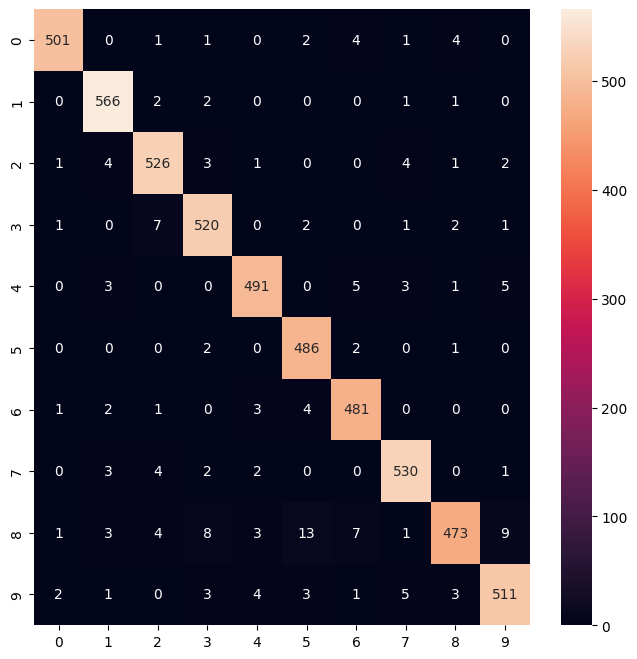

In [81]:
plt.figure(figsize=(8,8))
preds = np.argmax(vit_model.predict(X_valid),1)
sns.heatmap(confusion_matrix(y_valid,preds),annot=True,fmt='g')

In [82]:
print(classification_report(preds,y_valid))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       507
           1       0.99      0.97      0.98       582
           2       0.97      0.97      0.97       545
           3       0.97      0.96      0.97       541
           4       0.97      0.97      0.97       504
           5       0.99      0.95      0.97       510
           6       0.98      0.96      0.97       500
           7       0.98      0.97      0.97       546
           8       0.91      0.97      0.94       486
           9       0.96      0.97      0.96       529

    accuracy                           0.97      5250
   macro avg       0.97      0.97      0.97      5250
weighted avg       0.97      0.97      0.97      5250



In [31]:
vit_model.save("ViT4Digits.keras")

In [30]:
vit_pred = vit_model.predict(test)
preds = np.argmax(vit_pred,1)
pd.DataFrame({"ImageId":range(1,28001),"Label":preds}).to_csv("vit_res4.csv",index=False)

Patch_dimentions: 49
(32, 16, 64)
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<h2 style="color:blue"> Hybrid ViT

In [41]:
from tensorflow.keras.models import clone_model  

In [42]:
# Cloning Densenet to Use it as an hybrid model for ViT
densenet_model_copy = clone_model(densenet_model)  
densenet_model_copy.set_weights(densenet_model.get_weights())

densenet_model_copy.layers[-5]

<Conv2D name=conv2d_8, built=True>

In [43]:
densenet_4_vit_model = Model(densenet_model_copy.input,densenet_model_copy.layers[-5].output)
# densenet_4_vit_model.trainable = False

densenet_output_cnn = densenet_4_vit_model.output # outputs (7,7,64) 
flatten_densenet_output_cnn = tf.keras.layers.Reshape((49,64))(densenet_output_cnn)

pos_embed = tf.Variable(tf.random.normal((1,49,64)),trainable=True)
final_embedding = flatten_densenet_output_cnn + pos_embed
x = MultiHeadAttention(8,64)(final_embedding,final_embedding)
x = Dense(64,activation='relu')(x)
x = Dense(64)(x)
x = Dropout(0.4)(x)
x = Add()([x,final_embedding]) #Skip connection
x = LayerNormalization(axis=-1)(x) 
cls_token = GlobalAveragePooling1D()(x) #Creating cls token by pooling method
output = Dense(10, activation='softmax')(cls_token)


hybrid_vit_model = Model(densenet_4_vit_model.input,output )
hybrid_vit_model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import ReduceLROnPlateau  

lr_scheduler = ReduceLROnPlateau('accuracy', factor=0.5, patience=3)
hybrid_vit_model.fit(train_datagen.flow(X_train,y_train,batch_size=100),validation_data=valid_data,epochs=50,callbacks=[lr_scheduler]) #Epochs 50

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


368/368 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.9161 - loss: 0.3214 - val_accuracy: 0.9899 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9893 - loss: 0.0358 - val_accuracy: 0.9910 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9923 - loss: 0.0276 - val_accuracy: 0.9920 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9933 - loss: 0.0224 - val_accuracy: 0.9939 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9919 - loss: 0.0263 - val_accuracy: 0.9920 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9939 - loss: 0.0216 - val_accuracy: 0.9920 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9925 - loss: 0.0224

In [45]:
hybrid_vit_model.evaluate(valid_data)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0269


[0.021357569843530655, 0.9954285621643066]

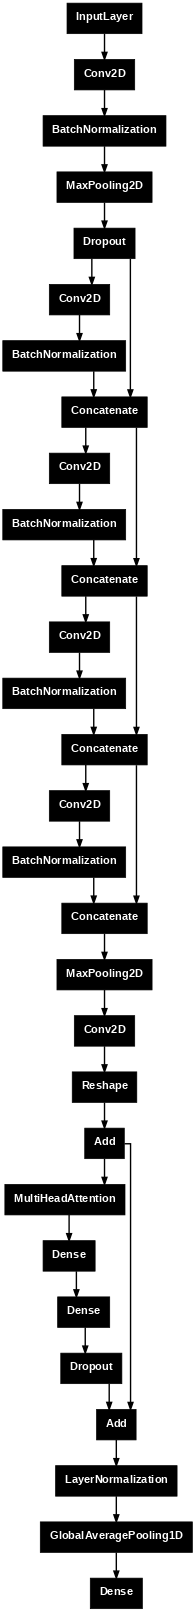

In [46]:
plot_model(hybrid_vit_model,to_file="hvit_struct.png",dpi=50)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

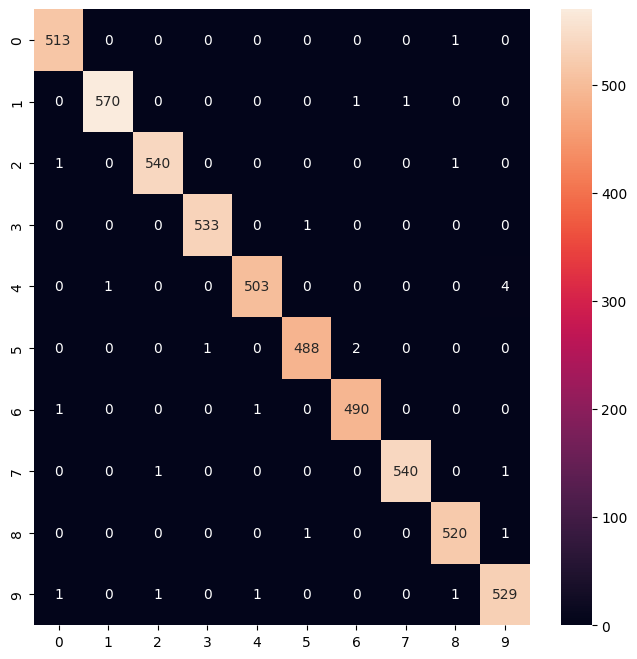

In [83]:
plt.figure(figsize=(8,8))
preds = np.argmax(hybrid_vit_model.predict(X_valid),1)
sns.heatmap(confusion_matrix(y_valid,preds),annot=True,fmt='g')

In [84]:
print(classification_report(preds,y_valid))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       516
           1       1.00      1.00      1.00       571
           2       1.00      1.00      1.00       542
           3       1.00      1.00      1.00       534
           4       0.99      1.00      0.99       505
           5       0.99      1.00      0.99       490
           6       1.00      0.99      0.99       493
           7       1.00      1.00      1.00       541
           8       1.00      0.99      1.00       523
           9       0.99      0.99      0.99       535

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [48]:
#Save Model
hybrid_vit_model.save("HybridViT4Digits.keras")

# Ensembling

<h2 style="color:green"> Weighted Sum

In [49]:
from sklearn.metrics import accuracy_score

In [34]:
resnet_model = tf.keras.models.load_model("/kaggle/input/models/tensorflow2/default/1/ResNet4Digits (1).keras")
densenet_model = tf.keras.models.load_model("/kaggle/input/models/tensorflow2/default/1/DenseNet4Digits (1).keras")
vit_model = tf.keras.models.load_model("/kaggle/input/models/tensorflow2/default/1/ViT4Digits (1).keras")
hybrid_vit_model = tf.keras.models.load_model("/kaggle/input/models/tensorflow2/default/1/ResNet4Digits (1).keras")

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 28, 28, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None, 'name': 'input_layer_3', 'inbound_nodes': []}, {'module': None, 'class_name': 'Patches', 'config': {'name': 'patches', 'stride': 7, 'patch_size': 7, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Patches', 'build_config': {'input_shape': [None, 28, 28, 1]}, 'name': 'patches', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 1], 'dtype': 'float32', 'keras_history': ['input_layer_3', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'Embeddings', 'config': {'num_patches': 16, 'projection_dim': 64, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': 'Embeddings', 'build_config': {'input_shape': [None, 16, 49]}, 'name': 'embeddings', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 49], 'dtype': 'float32', 'keras_history': ['patches', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'seed': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 16, 64], 'value_shape': [None, 16, 64]}}, 'name': 'multi_head_attention', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['embeddings', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['embeddings', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['embeddings', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'seed': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 16, 64], 'value_shape': [None, 16, 64]}}, 'name': 'multi_head_attention_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_1', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_6', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_7', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'seed': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 16, 64], 'value_shape': [None, 16, 64]}}, 'name': 'multi_head_attention_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_3', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_6', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_8', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'dense_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 64], [None, 16, 64]]}, 'name': 'add_7', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['dense_9', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'rms_scaling': False, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'layer_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['add_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 64]}, 'name': 'flatten_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136738989187728}, 'units': 10, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}, 'name': 'dense_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['flatten_3', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_3', 0, 0]], 'output_layers': [['dense_10', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 2.4414063659605745e-07, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Could not locate class 'Patches'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'Patches', 'config': {'name': 'patches', 'stride': 7, 'patch_size': 7, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Patches', 'build_config': {'input_shape': [None, 28, 28, 1]}, 'name': 'patches', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 1], 'dtype': 'float32', 'keras_history': ['input_layer_3', 0, 0]}}], 'kwargs': {}}]}

In [55]:
resnet_X_valid_preds = resnet_model.predict(X_valid)
densenet_X_valid_preds = densenet_model.predict(X_valid)
vit_X_valid_preds = vit_model.predict(X_valid)
Hvit_X_valid_preds = hybrid_vit_model.predict(X_valid)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [63]:
models = [resnet_model, densenet_model, vit_model, hybrid_vit_model]

data = [] # contains->[w1,w2,w3,w4,x_valid_acc]

In [64]:
for w1 in range(1,5):
    for w2 in range(1,5):
        for w3 in range(1,5):
            for w4 in range(1,5):
                weights = np.array([w1,w2,w3,w4])
                
                X_test_preds = np.array([resnet_X_valid_preds,densenet_X_valid_preds,vit_X_valid_preds,Hvit_X_valid_preds])
                weighted_X_valid_preds= np.tensordot(X_test_preds, weights,((0),(0)))
                weighted_X_valid_preds= np.argmax(weighted_X_valid_preds,1)
                weighted_accuracy_X_valid = accuracy_score(y_valid,weighted_X_valid_preds)
    
                data.append([w1,w2,w3,w4, weighted_accuracy_X_valid])

In [65]:
data = np.array(data)

In [66]:
X_valid_acc = data[:,4]

In [87]:
print(f"Max X_valid accuracy: {X_valid_acc.max()}, Index : {X_valid_acc.argmax()}\n Data :{data[X_valid_acc.argmax()]}")

Max X_valid accuracy: 0.9963809523809524, Index : 42
 Data :[1.         3.         3.         3.         0.99638095]


In [88]:
valid_preds = [model.predict(X_valid) for model in models]
preds= np.tensordot(valid_preds, [1,3,3,3],((0),(0)))
preds= np.argmax(preds,1)
print(classification_report(y_valid,preds))

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00       542
           3       1.00      1.00      1.00       534
           4       0.99      0.99      0.99       508
           5       0.99      1.00      0.99       491
           6       1.00      0.99      1.00       492
           7       1.00      0.99      1.00       542
           8       1.00      1.00      1.00       522
           9       0.99      1.00      0.99       533

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [85]:
test_preds = [model.predict(test) for model in models]
preds= np.tensordot(test_preds, [1,3,3,3],((0),(0)))
preds= np.argmax(preds,1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
pd.DataFrame({"ImageId":range(1,28001),'Label':preds}).to_csv("Weighted_result10.csv",index=False)